In [88]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from utils import read_raw, read_rgb, read_data, read_envi_ascii
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from machine_learning import DecisionTree, svm_classifier, RandomForest, AdaBoost, GradientBoosting, XGBoost, MLP, predict
import cv2

In [89]:
# Read data
data = read_envi_ascii('data/biaotu.txt')

huangqi = data['huangqi'][:, :110]
zazhi1 = data['zazhi1'][:, :110]
zazhi2 = data['zazhi2'][:, :110]
beijing = data['beijing'][:, :110]
gancaopian = data['gancaopian'][:, :110]
hongqi = data['hongqi'][:, :110]
huangqi_y = np.ones(huangqi.shape[0]) * 3
zazhi1_y = np.ones(zazhi1.shape[0]) * 1
zazhi2_y = np.ones(zazhi2.shape[0]) * 2
beijing_y = np.ones(beijing.shape[0]) * 0
gancaopian_y = np.ones(gancaopian.shape[0]) * 4
hongqi_y = np.ones(hongqi.shape[0]) * 5
data_x = np.concatenate((huangqi, zazhi1, zazhi2, beijing, gancaopian, hongqi), axis=0)
data_y = np.concatenate((huangqi_y, zazhi1_y, zazhi2_y, beijing_y, gancaopian_y, hongqi_y), axis=0)

In [90]:


select = SelectKBest(chi2, k=10)

x_new = select.fit_transform(data_x, data_y)

selected_features = select.get_support(indices=True)
print(selected_features)


[14 15 16 17 18 19 20 21 22 23]


In [91]:
from sklearn.model_selection import train_test_split
data_x = data_x[:, selected_features]
train_x, test_x, train_y, test_y = train_test_split(data_x ,data_y, test_size=0.3, stratify=data_y)

In [92]:
file_name = 'models/dt.p'
DecisionTree(train_x, train_y,test_x, test_y, file_name)

预测时间： 0.0
DT训练模型评分：1.0
DT待测模型评分：0.6837782340862423
DT预测结果：[0. 3. 2. 5. 4. 2. 4. 3. 5. 5. 2. 2. 4. 3. 4. 4. 4. 5. 2. 2. 0. 3. 0. 4.
 3. 5. 4. 2. 2. 5. 1. 0. 1. 4. 1. 2. 5. 5. 4. 1. 4. 3. 3. 1. 0. 5. 1. 4.
 1. 2. 0. 3. 0. 2. 0. 0. 5. 4. 5. 4. 4. 2. 1. 2. 1. 2. 5. 1. 1. 2. 5. 3.
 4. 5. 0. 1. 5. 5. 3. 0. 5. 5. 4. 1. 3. 5. 4. 1. 3. 5. 2. 0. 3. 1. 1. 2.
 5. 5. 2. 2. 5. 1. 1. 4. 0. 2. 4. 1. 1. 5. 2. 4. 2. 2. 4. 2. 2. 2. 2. 2.
 4. 0. 5. 0. 3. 2. 2. 1. 0. 1. 3. 3. 3. 5. 4. 1. 3. 4. 3. 3. 4. 4. 2. 1.
 3. 3. 0. 3. 3. 4. 1. 3. 4. 4. 0. 4. 4. 0. 0. 0. 1. 5. 3. 3. 2. 1. 4. 2.
 2. 3. 0. 2. 4. 1. 2. 2. 5. 2. 3. 4. 0. 5. 5. 5. 0. 0. 3. 5. 5. 1. 3. 2.
 3. 4. 5. 4. 0. 3. 3. 0. 2. 3. 0. 4. 1. 5. 5. 1. 2. 0. 1. 3. 2. 0. 5. 3.
 4. 0. 1. 3. 2. 5. 3. 5. 2. 0. 1. 0. 5. 3. 0. 0. 1. 1. 2. 5. 5. 0. 2. 4.
 5. 2. 0. 3. 1. 3. 1. 1. 3. 4. 2. 5. 4. 1. 1. 0. 5. 3. 4. 1. 4. 0. 3. 4.
 5. 3. 5. 2. 5. 2. 0. 2. 1. 4. 0. 0. 2. 2. 5. 5. 2. 0. 1. 0. 2. 1. 0. 2.
 2. 4. 2. 5. 1. 2. 5. 4. 3. 5. 1. 2. 0. 4. 5. 4. 1. 4. 1. 5. 4. 3.

In [93]:
data_x = read_raw('data/newrawfile_ref.raw', shape=(750, 288, 384), setect_bands=selected_features)

In [94]:
data_x_shape = data_x.shape
data_x = data_x.reshape(-1, data_x.shape[2])
data_y = predict(data_x, file_name)

预测时间： 0.01695418357849121


In [95]:
data_y = data_y.reshape(data_x_shape[0], data_x_shape[1]).astype(np.uint8)

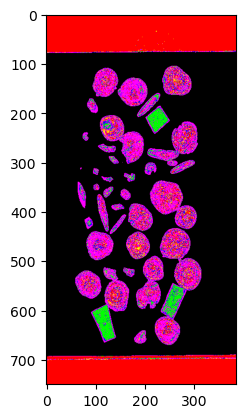

In [96]:
pre_data_y = np.zeros((data_y.shape[0], data_y.shape[1], 3), dtype=np.uint8)

pre_data_y[data_y == 0] = [0, 0, 0]
pre_data_y[data_y == 1] = [255, 0, 0]
pre_data_y[data_y == 2] = [0, 255, 0]
pre_data_y[data_y == 3] = [0, 0, 255]
pre_data_y[data_y == 4] = [255, 255, 0]
pre_data_y[data_y == 5] = [255, 0, 255]



plt.imshow(pre_data_y)
plt.savefig('result1.png', dpi=300)

In [97]:
# 连通域分析
from scipy import ndimage
labels, num_features = ndimage.label(data_y)
for i in range(1, num_features + 1):
    mask = (labels == i)
    counts = np.bincount(data_y[mask])
    # 如果2的个数在所有的像素点中占比超过25%，则认为是2，否则认为0和1中最多的是哪个就是哪个
    # 如果有count[2]，才进入判断，否则直接认为是0或者1
    # if len(counts) > 2 and counts[2] / np.sum(counts) > 0.20:
    #     data_y[mask] = 2
    # else:
    #     data_y[mask] = np.argmax(counts)
    data_y[mask] = np.argmax(counts)

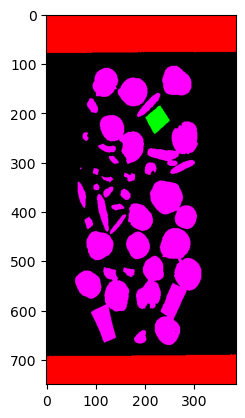

In [98]:
pre_data_y = np.zeros((data_y.shape[0], data_y.shape[1], 3), dtype=np.uint8)

pre_data_y[data_y == 0] = [0, 0, 0]
pre_data_y[data_y == 1] = [255, 0, 0]
pre_data_y[data_y == 2] = [0, 255, 0]
pre_data_y[data_y == 3] = [0, 0, 255]
pre_data_y[data_y == 4] = [255, 255, 0]
pre_data_y[data_y == 5] = [255, 0, 255]



plt.imshow(pre_data_y)
plt.savefig('result.png', dpi=300)